In [1]:
#import libary
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import glob
%matplotlib inline

### Camera calibration

In [2]:
#camera calibration
def calibrate_camera(chessborad_dir, nx, ny):
    chessborad_images = glob.glob(chessborad_dir)
    
    img_shape = cv2.imread(chessborad_images[0]).shape
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for chessborad_img in chessborad_images:
        gray = cv2.cvtColor(cv2.imread(chessborad_img), cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape[1::-1], None, None)
    return mtx, dist

def undist_img(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

### Thresholding

In [3]:
#sobel threshold
def sobel_filter(image, way, sobel_kernel = 3, thres_min=0, thres_max=255):
    assert(way in ['x','y','mag_grad'])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if way=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    elif way=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    elif way=='mag_grad':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
        sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    else:
        print("Invalid input in sobel ways")
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    #create mask
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel>thres_min) & (scaled_sobel<thres_max)] = 1
    return mask

#direction filter
def direction_filter(image, thres_min=0, thres_max=np.pi/2, sobel_kernel=3):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel))
    direction_sobel = np.arctan2(sobely, sobelx)
    mask = np.zeros_like(direction_sobel)
    mask[(direction_sobel>thres_min) & (direction_sobel<thres_max)] = 1
    return mask

#color filter
def color_filter(image, way, c, thres_min=0, thres_max=255):
    assert(way in ['hsv', 'hls','rgb'])
    assert(c in ['h','s','v','l','r','g','b'])
    if way=='hsv':
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if c=='h':
            channel = hsv[:,:,0]
        elif c=='s':
            channel = hsv[:,:,1]
        elif c=='v':
            channel = hsv[:,:,2]
        else:
            print('Please select a valid channel')
    elif way=='hls':
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        if c=='h':
            channel = hls[:,:,0]
        elif c=='l':
            channel = hls[:,:,1]
        elif c=='s':
            channel = hls[:,:,2]
        else:
            print('Please select a valid channel')
    elif way=='rgb':
        if c=='r':
            channel = image[:,:,0]
        elif c=='g':
            channel = image[:,:,1]
        elif c=='b':
            channel = image[:,:,2]
        else:
            print('Please select a valid channel')
            
    mask = np.zeros_like(channel)
    mask[(channel>thres_min) & (channel<thres_max)] = 1
    return mask



### Perspective transform

In [4]:
def perspective_trans(image, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    image_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

### Find lane line

In [5]:
#use sliding window to find out where is the lane located in the small window,
#and drawing a two boxes to indicate the position of left lane and right lane
#return the peak-point coordinate's lists of the left-lane and the right lane
def windows_filter(warped_image, nwindows=9, margin=100, minpix=50):
    histogram = np.sum(warped_image[warped_image.shape[0]//2:, :], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    
    window_height = np.int(warped_image.shape[0]//2)
    
    nonzero = warped_image.nonzero()  #nonzero() method return two arrary, first is non-zero pixels' x-axis indexs , second is non-zero pixels' y-axis idnexs
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    #use two lists to contain the coordinate of the peak-points 
    left_lane_inds = []
    right_lane_inds = []
    
    #window sliding
    for window in range(nwindows):
        win_y_low = warped_image.shape[0] - (window+1)*window_height
        win_y_high = warped_image.shape[0] - window*window_height
        win_leftx_low = leftx_current - margin
        win_leftx_high = leftx_current + margin
        win_rightx_low = rightx_current - margin
        win_rightx_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy>=win_y_low)&(nonzeroy<=win_y_high) & 
                          (nonzerox>=win_leftx_low)&(nonzerox<=win_leftx_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low)&(nonzeroy<=win_y_high) &
                           (nonzerox>=win_rightx_low)&(nonzerox<=win_rightx_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    try:
        left_lane_good_inds = np.concatenate(left_lane_inds)
        right_lane_good_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
        
    leftx = nonzerox[left_lane_good_inds]
    lefty = nonzeroy[left_lane_good_inds]
    rightx = nonzerox[right_lane_good_inds]
    righty = nonzeroy[right_lane_good_inds]
        
    return leftx, lefty, rightx, righty

#by using the return of windows filter, use these indices to fit a second order polynomial function, and return the parameters
def fit_polynomial(warped_image, leftx, lefty, rightx, righty):    
    #parameters of the second order polynomial function
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    #lane line function
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    return left_fit, right_fit, left_fitx, right_fitx

def draw_lines(warped_image, left_fitx, right_fitx, leftx=None, lefty=None, rightx=None, righty=None, draw_pix=False):
    out_img = np.dstack((warped_image, warped_image, warped_image))
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    
    if draw_pix:
        out_img[lefty, leftx] = [255,0,0]
        out_img[righty, rightx] = [0,0,255]
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img

### Search from prior

In [6]:
#Use the previous polynomial to skip the sliding window, feed in two polynomial parameters from the result of fit_polynomial
def search_around_poly(warped_image, left_fit, right_fit, margin=100, plotline=False):
    #isolate the activate pixels
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    
    #fit a new polynomail
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx,2 )
  
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    output_img = np.dstack((warped_image, warped_image, warped_image))*255
    window_img = np.zeros_like(output_img)
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
    result = cv2.addWeighted(output_img, 1, window_img, 0.3, 0)
    
    if plotline:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    result[lefty, leftx] = [255,0,0]
    result[righty, rightx] = [0,0,255]
    
    return result, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty

### Curvature and Deviation

In [39]:
#calculating the curvature and the car's deviation from the center of the detected lane
def curvature(image, left_fit, right_fit):
    ploty = np.linspace(0, image.shape[1]-1, image.shape[1])
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720
    xm_per_pix = 3.7/800
    left_a = xm_per_pix/(ym_per_pix**2)*left_fit[0]
    left_b = (xm_per_pix/ym_per_pix)*left_fit[1]
    left_c = left_fit[2]
    
    right_a = xm_per_pix/(ym_per_pix**2)*right_fit[0]
    right_b = (xm_per_pix/ym_per_pix)*right_fit[1]
    right_c = right_fit[2]
    
    left_cur = np.power(1 + np.square(2*left_a*y_eval*ym_per_pix+ left_b), 3/2) / np.absolute(2*left_a)
    right_cur = np.power(1 + np.square(2*right_a*y_eval*ym_per_pix + right_b), 3/2) / np.absolute(2*right_a)
    cur = (left_cur+right_cur)/2
    
    mid_point = image.shape[0]//2
    bottom_left_x = left_fit[0]*(image.shape[1])**2 + left_fit[1]*(image.shape[1]) + left_fit[2]
    bottom_right_x = right_fit[0]*(image.shape[1])**2 + right_fit[1]*(image.shape[1]) + right_fit[2]
    lane_center = (bottom_right_x-bottom_left_x)/2
    deviation = (mid_point - lane_center)*xm_per_pix
    return cur, deviation

### Draw lane

In [41]:
def fill_lane(image, warped_image, undist_image, left_fitx, right_fitx, leftx, lefty, rightx, righty, Minv):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero,warp_zero))
    
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    color_warp[lefty, leftx] = [255,0,0]
    color_warp[righty, rightx] = [0,0,255]

    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    return result

### Tuning

test image with shape:  (720, 1280, 3)


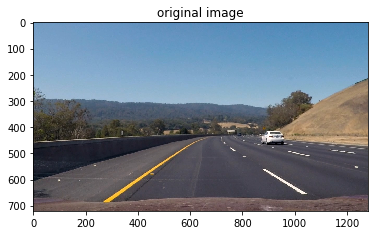

In [42]:
test_image = mpimg.imread("./test_images/test3.jpg")
print("test image with shape: ", test_image.shape)
plt.title('original image')
plt.imshow(test_image)

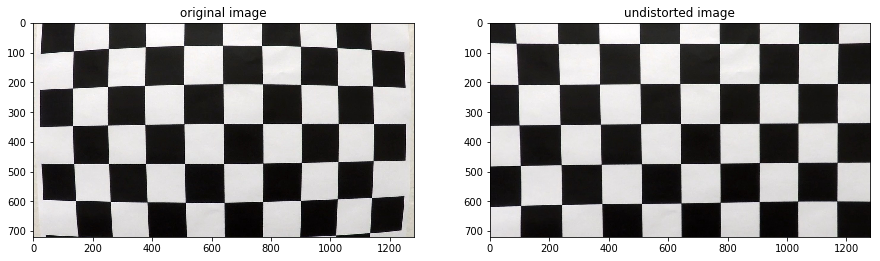

In [43]:
#image test
chessborad_dir = "./camera_cal/calibration*.jpg"
mtx, dist = calibrate_camera(chessborad_dir, 9, 6)

calibration_test = mpimg.imread("./camera_cal/calibration1.jpg")

undist_test = undist_img(calibration_test, mtx, dist)

plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(calibration_test)
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.imshow(undist_test)
plt.show()

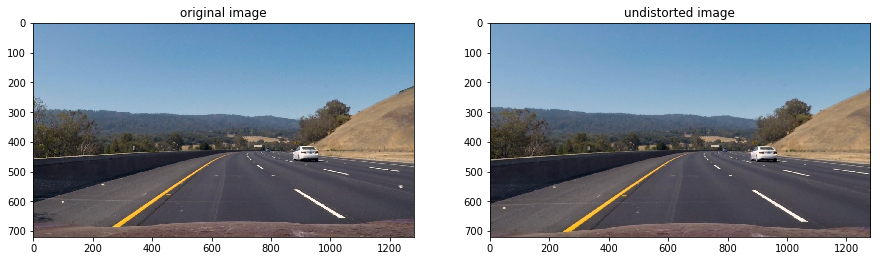

In [44]:
#test on true image
undist_test_img = undist_img(test_image, mtx, dist)

plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(test_image)
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.imshow(undist_test_img)
plt.show()

#we can see tiny change at the bottom of the image 

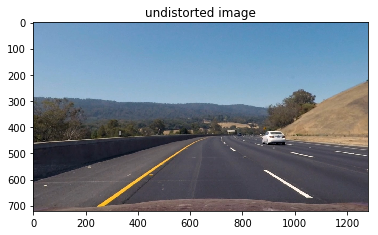

In [45]:
plt.title('undistorted image')
plt.imshow(undist_test_img)
plt.show()

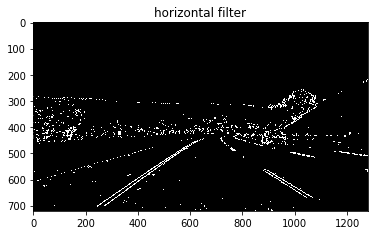

In [46]:
sobeled = sobel_filter(undist_test_img, way='x', thres_min=20, thres_max=180)
plt.title('horizontal filter')
plt.imshow(sobeled, cmap='gray')

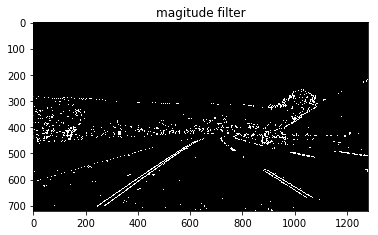

In [47]:
mag_sobeled = sobel_filter(undist_test_img, way='mag_grad', thres_min=20, thres_max=180)
plt.title('magitude filter')
plt.imshow(sobeled, cmap='gray')

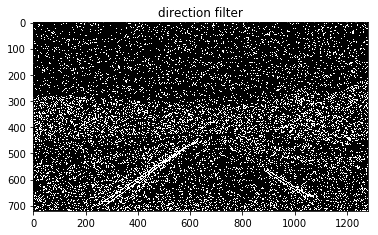

In [48]:
sobeled_dir = direction_filter(undist_test_img, thres_min=0.8, thres_max=1.2)
plt.title('direction filter')
plt.imshow(sobeled_dir, cmap='gray')

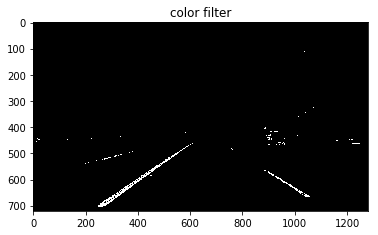

In [49]:
colored = color_filter(undist_test_img, way='hls', c='s', thres_min=120, thres_max=255)
plt.title('color filter')
plt.imshow(colored ,cmap='gray')

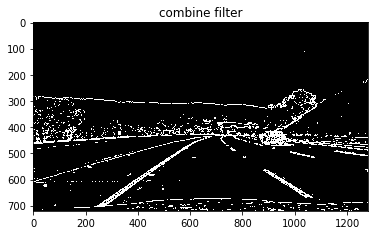

In [50]:
combine = np.zeros_like(colored)
combine[(colored==1)|(sobeled==1)|(mag_sobeled==1)]=1
plt.title('combine filter')
plt.imshow(combine, cmap='gray')

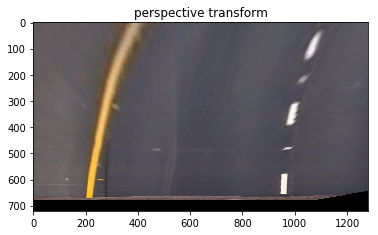

In [51]:
#tuning the source matrix and destination matrix 
src = np.float32([[(720,460),(1200, 720),(150, 720),(580, 460)]])
dst = np.float32([[(1000, 100),(1000, 680), (150, 680), (150, 100)]])
warped_image, M, Minv = perspective_trans(test_image, src, dst)
plt.title('perspective transform')
plt.imshow(warped_image)

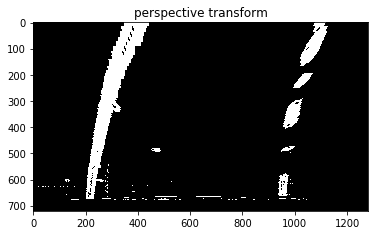

In [52]:
#remember the order of points is clockwise starting from 0'oclock
warped_image, M, Minv = perspective_trans(combine, src, dst)
plt.title('perspective transform')
plt.imshow(warped_image, cmap='gray')

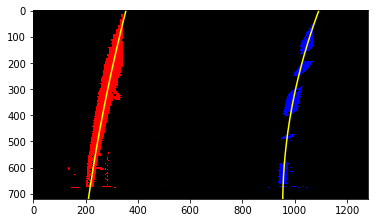

In [53]:
leftx, lefty, rightx, righty = windows_filter(warped_image)
left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped_image, leftx, lefty, rightx, righty)
out_img = draw_lines(warped_image,left_fitx, right_fitx, leftx, lefty, rightx, righty, draw_pix=True)
plt.imshow(out_img)

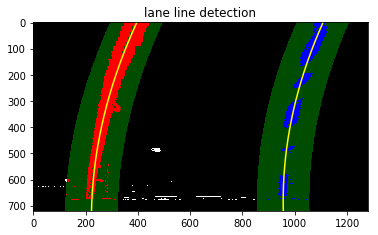

In [54]:
image, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty= search_around_poly(warped_image, left_fit, right_fit, plotline=True)
plt.title('lane line detection')
plt.imshow(image)

In [55]:
cur, dev = curvature(image, left_fit, right_fit)
print(cur, dev)

596.6797829320244 -0.10689768259475095


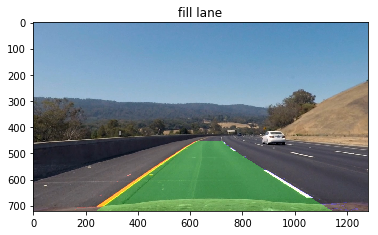

In [56]:
result = fill_lane(test_image, warped_image, undist_test_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, Minv)
plt.title('fill lane')
plt.imshow(result)

### PipeLine

In [57]:
def pipeline(image):
    #image test
    undist_test_img = undist_img(image, mtx, dist)
    sobeled = sobel_filter(undist_test_img, way='x', thres_min=20, thres_max=180)
    colored = color_filter(undist_test_img, way='hls', c='s', thres_min=165, thres_max=255)
    mag_sobeled = sobel_filter(undist_test_img, way='mag_grad', thres_min=20, thres_max=180)
    combine = np.zeros_like(colored)
    combine[(colored==1)|(sobeled==1)|(mag_sobeled==1)]=1
    src = np.float32([[(720,460),(1200, 720),(150, 720),(580, 460)]])
    dst = np.float32([[(1000, 100),(1000, 680), (150, 680), (150, 100)]])
    warped_image, M, Minv = perspective_trans(combine, src, dst)
    leftx, lefty, rightx, righty = windows_filter(warped_image)
    left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped_image, leftx, lefty, rightx, righty)
    image, left_fit, right_fit, left_fitx, right_fitx , leftx, lefty, rightx, righty= search_around_poly(warped_image, left_fit, right_fit)
    cur, dev = curvature(image, left_fit, right_fit)
    result = fill_lane(image, warped_image, undist_test_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, Minv)
    font = cv2.FONT_HERSHEY_COMPLEX
    cur_text = "Radius of curvature {:.3f} meters".format(cur)
    dev_text = "car's deviation from center {:.3f} meters".format(dev)
    cv2.putText(result, cur_text, (image.shape[0]//3, 50), font, 1.2, (0,0,0), 2)
    cv2.putText(result, dev_text, (image.shape[0]//3, 100), font, 1.2, (0,0,0), 2)

    return result

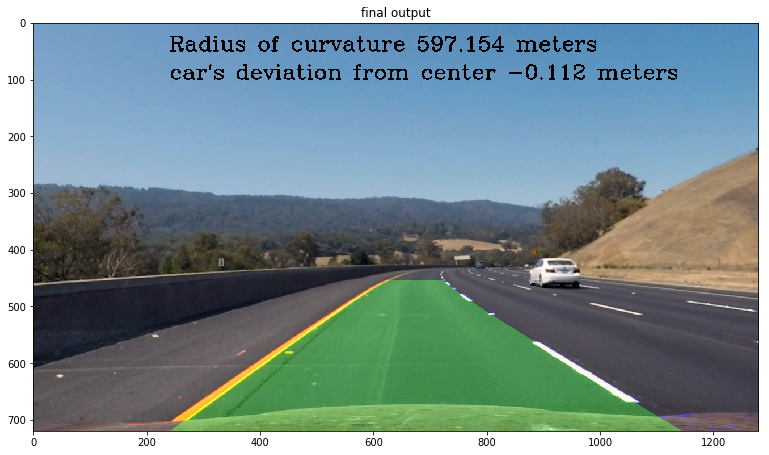

In [58]:
chessborad_dir = "./camera_cal/calibration*.jpg"
mtx, dist = calibrate_camera(chessborad_dir, 9, 6)

test_image = mpimg.imread("./test_images/test3.jpg")
result_image = pipeline(test_image)

plt.figure(figsize=(13,10))
plt.title('final output')
plt.imshow(result_image)

In [59]:
#output test images
import imageio

test_image_files = "./test_images/test*.jpg"

for i, image in enumerate(glob.glob(test_image_files)):
    image = mpimg.imread(image)
    result = pipeline(image)
    imageio.imwrite('./output_images/test{}.jpg'.format(i), result)

### Video pipeline

In [60]:
from IPython.display import HTML

In [61]:
reader = imageio.get_reader("./project_video.mp4")
writer = imageio.get_writer('./output_video/output_video.mp4', fps=25)

left_fit = []
right_fit = []


for i, img in enumerate(reader):
    undist = undist_img(img, mtx, dist)
    sobeled = sobel_filter(undist, way='x', thres_min=20, thres_max=180)
    colored = color_filter(undist, way='hls', c='s', thres_min=165, thres_max=255)
    combine = np.zeros_like(colored)
    combine[(colored==1)|(sobeled==1)]=1
    src = np.float32([[(720,460),(1200, 720),(150, 720),(580, 460)]])
    dst = np.float32([[(1000, 100),(1000, 680), (150, 680), (150, 100)]])
    warped_img, M, Minv = perspective_trans(combine, src, dst)
    
    if i%100 == 0:
        print(i, " frames has been process")

    if (len(left_fit)>0) and (len(right_fit>0)):
        _, left_fit, right_fit, left_fitx, right_fitx , leftx, lefty, rightx, righty= search_around_poly(warped_img, left_fit, right_fit)
        
    else:
        leftx, lefty, rightx, righty = windows_filter(warped_img)
        left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped_img, leftx, lefty, rightx, righty)
        
    cur, dev = curvature(img, left_fit, right_fit)
    result = fill_lane(img, warped_img, undist, left_fitx, right_fitx, leftx, lefty, rightx, righty, Minv)
    font = cv2.FONT_HERSHEY_COMPLEX
    
    cur_text = "Radius of curvature {:.3f} meters".format(cur)
    dev_text = "Car's deviation from center {:.3f} meters".format(dev)
    cv2.putText(result, cur_text, (image.shape[0]//3, 50), font, 1.2, (0,0,0), 2)
    cv2.putText(result, dev_text, (image.shape[0]//3, 100), font, 1.2, (0,0,0), 2)
                        
    writer.append_data(result)
    
writer.close()

0  frames has been process
100  frames has been process
200  frames has been process
300  frames has been process
400  frames has been process
500  frames has been process
600  frames has been process
700  frames has been process
800  frames has been process
900  frames has been process
1000  frames has been process
1100  frames has been process
1200  frames has been process


In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_video/output_video.mp4'))